In [10]:
import requests
from requests_futures.sessions import FuturesSession
import datetime as dt
import time
import sys
from drafterANN import *
import socket
import pickle

api_keys = ['FE70CE9FC0D6D99279498CE852587F59','2FEC67172AAC0C393EC209A225A7E51E']
api_key_num = 1
api_key = api_keys[api_key_num]
sleep_time = 7

drafter = DotoAnn()

leagues = ['4357', '4554', '4579', '4461', '3454', '3781', '4210', '3865', '4266', '4289', '4301', '3902', '4325']

i = 0
errors = 0

session = FuturesSession()

def next_matches(league_id):
    url = 'https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?key=' + api_key + '&league_id=' + league_id + '&start_at_match_id=' + str(next_id) + '&min_players=10'
    return session.get(url, timeout=4)

def next_match(match_id):
    url = 'https://api.steampowered.com/IDOTA2Match_570/GetMatchDetails/V001/?key=' + api_key + '&match_id=' + str(match_id)
    return session.get(url, timeout=4)

matches_bulk = list()

for league_id in leagues:
    next_id = ''
    req = next_matches(league_id)
    while True:
        try:
            try:
                r = req.result()
            except (requests.ConnectionError, requests.Timeout, socket.timeout):
                print("Unexpected error:", sys.exc_info()[0])
                errors += 1
                time.sleep(sleep_time)
                req = next_matches(league_id)
                continue

            if (r.status_code != 200):
                errors += 1
                time.sleep(sleep_time)
                req = next_matches(league_id)
                continue
            if 'matches' in r.json()['result']:
                matches = r.json()['result']['matches']
            else:
                time.sleep(sleep_time)
                req = next_matches(league_id)
                continue

            if len(matches) == 0:
                break

            next_id = matches[-1]['match_id'] - 1
            req = next_matches(league_id)

            for match in matches:
                m_req = next_match(match['match_id'])

                m = dict(id=match['match_id'])
                r_heroes = []
                d_heroes = []
                for player in match['players']:
                    if player['player_slot'] < 100:
                        r_heroes.append(str(player['hero_id']))
                    else:
                        d_heroes.append(str(player['hero_id']))
                m['radiant_heroes'] = ",".join(r_heroes)
                m['dire_heroes'] = ",".join(d_heroes)

                while True:
                    try:
                        m_res = m_req.result()
                    except (requests.ConnectionError, requests.Timeout, socket.timeout):
                        print("Unexpected error:", sys.exc_info()[0])
                        errors += 1
                        time.sleep(sleep_time)
                        m_req = next_match(match['match_id'])
                        continue
                    if (m_res.status_code != 200):
                        errors += 1
                        time.sleep(sleep_time)
                        m_req = next_match(match['match_id'])
                        continue
                    if 'radiant_win' in m_res.json()['result']:
                        rad_win = m_res.json()['result']['radiant_win']
                    else:
                        time.sleep(sleep_time)
                        m_req = next_match(match['match_id'])
                        continue
                    m['radiant_win'] = rad_win
                    break
                matches_bulk.append(m)
        except BaseException as e:
            print("Errors: ", errors)
            raise e

with open('data/league_matches.pickle','wb') as f:
    pickle.dump(matches_bulk,f)

In [3]:
from drafterANN import *
drafter = DotoAnn()

epoch_size = 3000
matches_bulk = list()

for m in Match.select().order_by(Match.seq_num.desc()).limit(epoch_size):
    match = {'radiant_heroes': m.radiant_heroes, 'dire_heroes': m.dire_heroes, 'radiant_win': m.radiant_win}
    matches_bulk.append(match)
    
print(len(matches_bulk))

3000


In [34]:
from drafterANN import *
import pickle

with open('data/league_matches.pickle','rb') as f:
     matches_bulk = pickle.load(f)
print(len(matches_bulk))

def check_accuracy(mmr):
    ys = []
    for x in mmr:
        avg_certainty = 0
        correct_preds = 0
        
        batch_xs = np.zeros((len(matches_bulk), n_input), np.int)
        batch_ys = np.zeros((len(matches_bulk), n_out), np.int)
        for i,m in enumerate(matches_bulk):
            xs = np.zeros((1, n_input), np.int)
            for h in m['radiant_heroes'].split(","):
                xs[0][int(h)] = 1
            for h in m['dire_heroes'].split(","):
                xs[0][int(h) + max_heroes] = 1
            batch_xs[i] = xs
            outs = np.zeros((1, n_out), np.int)
            outs[0][not m['radiant_win']] = 1
            batch_ys[i] = outs
        out = drafter.run(batch_xs, x)
        
        i2=0
        for i, m in enumerate(out):
            certainty = abs(m[0] - 0.5)
            if (certainty > 0.0):
                avg_certainty += certainty
                correct_preds += np.argmax(m) == np.argmax(batch_ys[i])
                i2+=1
        print("Accuracy", correct_preds/i2)
        print("Sample", i2)
        print("Avg Certainty", avg_certainty/i2 + 0.5)
        ys.append(correct_preds/i2)
    return ys


x = [1000,2000,3000,4000,5000,6000,6500,7000,8000,9000]
y = check_accuracy(x)

2390


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


Accuracy 0.558577405858
Sample 2390
Avg Certainty 0.617887214859
Accuracy 0.566527196653
Sample 2390
Avg Certainty 0.616170451711
Accuracy 0.566945606695
Sample 2390
Avg Certainty 0.614732327716
Accuracy 0.565271966527
Sample 2390
Avg Certainty 0.613555264288
Accuracy 0.567364016736
Sample 2390
Avg Certainty 0.612696401953
Accuracy 0.569874476987
Sample 2390
Avg Certainty 0.612142467854
Accuracy 0.572384937238
Sample 2390
Avg Certainty 0.61197402281
Accuracy 0.571966527197
Sample 2390
Avg Certainty 0.611899000674
Accuracy 0.565271966527
Sample 2390
Avg Certainty 0.612012011359
Accuracy 0.566108786611
Sample 2390
Avg Certainty 0.61249927469


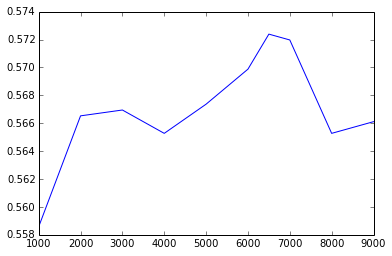

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x,y)